In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets.datasets import get_wine_dataloader, get_iris_dataloader, get_australian_dataloader, get_10x_73k_dataloader
from sklearn.manifold import TSNE

cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

## Wine

In [2]:
n_clusters = 3
batch_size = 89
dataloader, data_shape = get_wine_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 5

## Iris

In [2]:
n_clusters = 3
batch_size = 50
dataloader, data_shape = get_iris_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 3
h2 = 15
latent_dim = 2

## Australian

In [2]:
n_clusters = 2
batch_size = 69
dataloader, data_shape = get_australian_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 3

## 10x_73k

In [2]:
n_clusters = 8
batch_size = 256
dataloader, data_shape = get_10x_73k_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 500
h2 = 1500
latent_dim = 10

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, latent_dim, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(latent_dim),
            
            #nn.Linear(h3, h4, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h4),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_dim, h1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h1),
            
            nn.Linear(latent_dim, n_clusters, bias=True),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            #nn.Linear(h4, h3, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h3),
            
            nn.Linear(latent_dim, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, data_shape, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMin(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmin(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

autoencoder = Autoencoder(100)
autoencoder = autoencoder.to(device)

In [6]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering).to(device)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape).to(device)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

for epoch in range(1000):
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, loss))

Epoch: 0 Rec: 0.0121 
Epoch: 1 Rec: 0.0109 
Epoch: 2 Rec: 0.0109 
Epoch: 3 Rec: 0.0104 
Epoch: 4 Rec: 0.0150 
Epoch: 5 Rec: 0.0109 
Epoch: 6 Rec: 0.0104 
Epoch: 7 Rec: 0.0103 
Epoch: 8 Rec: 0.0103 
Epoch: 9 Rec: 0.0102 
Epoch: 10 Rec: 0.0101 
Epoch: 11 Rec: 0.0100 
Epoch: 12 Rec: 0.0098 
Epoch: 13 Rec: 0.0097 
Epoch: 14 Rec: 0.0097 
Epoch: 15 Rec: 0.0097 
Epoch: 16 Rec: 0.0097 
Epoch: 17 Rec: 0.0096 
Epoch: 18 Rec: 0.0096 
Epoch: 19 Rec: 0.0056 
Epoch: 20 Rec: 0.0054 
Epoch: 21 Rec: 0.0054 
Epoch: 22 Rec: 0.0054 
Epoch: 23 Rec: 0.0055 
Epoch: 24 Rec: 0.0055 
Epoch: 25 Rec: 0.0055 
Epoch: 26 Rec: 0.0055 
Epoch: 27 Rec: 0.0054 
Epoch: 28 Rec: 0.0054 
Epoch: 29 Rec: 0.0054 
Epoch: 30 Rec: 0.0055 
Epoch: 31 Rec: 0.0054 
Epoch: 32 Rec: 0.0054 
Epoch: 33 Rec: 0.0054 
Epoch: 34 Rec: 0.0054 
Epoch: 35 Rec: 0.0054 
Epoch: 36 Rec: 0.0054 
Epoch: 37 Rec: 0.0054 
Epoch: 38 Rec: 0.0054 
Epoch: 39 Rec: 0.0054 
Epoch: 40 Rec: 0.0054 
Epoch: 41 Rec: 0.0054 
Epoch: 42 Rec: 0.0053 
Epoch: 43 Rec: 0.0055

In [6]:
lamda = 100
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_dim))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(200):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMin(real_data).to(device)
        code = autoencoder.encoder(real_data).to(device)
        s = soft_silhouette(code, soft_clustering, requires_distance_grad=True)
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = transform_clusters_to_labels(soft_clustering, labels)
    
    accuracy = accuracy_score(real_labels, predicted_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, accuracy, nmi))

Epoch: 0 L: 0.0116 Rec: 0.0225 Soft SIL: -0.01 ACC: 0.63 NMI: 0.38 
Epoch: 1 L: 0.0402 Rec: 0.0181 Soft SIL: 0.02 ACC: 0.62 NMI: 0.36 
Epoch: 2 L: 0.0775 Rec: 0.0184 Soft SIL: 0.06 ACC: 0.65 NMI: 0.40 
Epoch: 3 L: 0.1085 Rec: 0.0180 Soft SIL: 0.09 ACC: 0.69 NMI: 0.40 
Epoch: 4 L: 0.1077 Rec: 0.0178 Soft SIL: 0.09 ACC: 0.70 NMI: 0.42 
Epoch: 5 L: 0.1155 Rec: 0.0168 Soft SIL: 0.10 ACC: 0.68 NMI: 0.43 
Epoch: 6 L: 0.1389 Rec: 0.0165 Soft SIL: 0.12 ACC: 0.67 NMI: 0.43 
Epoch: 7 L: 0.1578 Rec: 0.0162 Soft SIL: 0.14 ACC: 0.66 NMI: 0.52 
Epoch: 8 L: 0.1684 Rec: 0.0161 Soft SIL: 0.15 ACC: 0.68 NMI: 0.56 
Epoch: 9 L: 0.1788 Rec: 0.0157 Soft SIL: 0.16 ACC: 0.68 NMI: 0.56 
Epoch: 10 L: 0.1898 Rec: 0.0156 Soft SIL: 0.17 ACC: 0.68 NMI: 0.56 
Epoch: 11 L: 0.2010 Rec: 0.0154 Soft SIL: 0.19 ACC: 0.68 NMI: 0.56 
Epoch: 12 L: 0.2112 Rec: 0.0152 Soft SIL: 0.20 ACC: 0.69 NMI: 0.59 
Epoch: 13 L: 0.2218 Rec: 0.0151 Soft SIL: 0.21 ACC: 0.69 NMI: 0.59 
Epoch: 14 L: 0.2325 Rec: 0.0150 Soft SIL: 0.22 ACC: 0.70 

Epoch: 123 L: 0.9140 Rec: 0.0120 Soft SIL: 0.90 ACC: 0.92 NMI: 0.77 
Epoch: 124 L: 0.9128 Rec: 0.0120 Soft SIL: 0.90 ACC: 0.92 NMI: 0.77 
Epoch: 125 L: 0.9171 Rec: 0.0120 Soft SIL: 0.91 ACC: 0.92 NMI: 0.77 
Epoch: 126 L: 0.9187 Rec: 0.0119 Soft SIL: 0.91 ACC: 0.92 NMI: 0.77 
Epoch: 127 L: 0.9168 Rec: 0.0119 Soft SIL: 0.90 ACC: 0.93 NMI: 0.79 
Epoch: 128 L: 0.9241 Rec: 0.0119 Soft SIL: 0.91 ACC: 0.92 NMI: 0.77 
Epoch: 129 L: 0.9162 Rec: 0.0119 Soft SIL: 0.90 ACC: 0.92 NMI: 0.77 
Epoch: 130 L: 0.9228 Rec: 0.0119 Soft SIL: 0.91 ACC: 0.92 NMI: 0.77 
Epoch: 131 L: 0.9209 Rec: 0.0119 Soft SIL: 0.91 ACC: 0.93 NMI: 0.79 
Epoch: 132 L: 0.9258 Rec: 0.0118 Soft SIL: 0.91 ACC: 0.92 NMI: 0.77 
Epoch: 133 L: 0.9282 Rec: 0.0119 Soft SIL: 0.92 ACC: 0.92 NMI: 0.77 
Epoch: 134 L: 0.9309 Rec: 0.0118 Soft SIL: 0.92 ACC: 0.93 NMI: 0.79 
Epoch: 135 L: 0.9290 Rec: 0.0118 Soft SIL: 0.92 ACC: 0.93 NMI: 0.79 
Epoch: 136 L: 0.9311 Rec: 0.0118 Soft SIL: 0.92 ACC: 0.93 NMI: 0.79 
Epoch: 137 L: 0.9309 Rec: 0.0118 S

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.760118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.719353
[t-SNE] KL divergence after 300 iterations: 0.196190


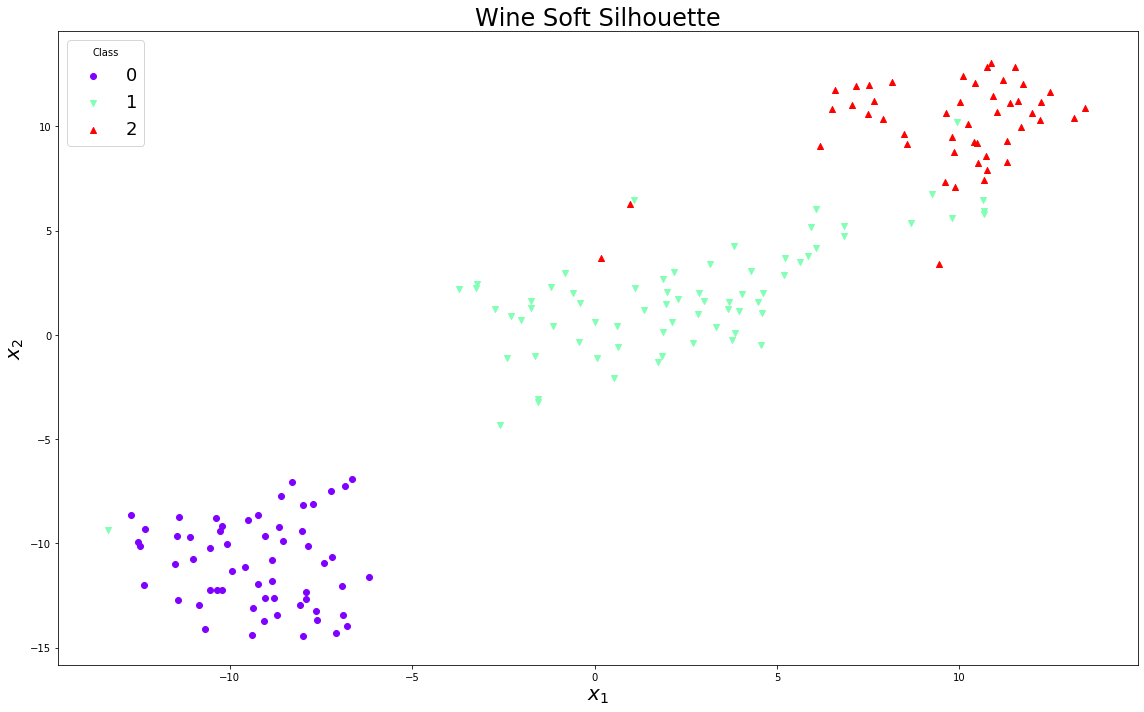

In [7]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')